In [10]:
%pip install face_recognition opencv-python-headless pillow pytesseract numpy matplotlib scikit-image ipywidgets tesseract --quiet

Note: you may need to restart the kernel to use updated packages.


In [15]:
# run in a notebook cell
!pip install --upgrade pip
!pip install face_recognition opencv-python-headless pillow pytesseract numpy matplotlib scikit-image ipywidgets
# Optional (better face embeddings). If you want to use it later, install:
# !pip install insightface onnxruntime

  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)


ERROR: To modify pip, please run the following command:
C:\Users\mujta\anaconda3\python.exe -m pip install --upgrade pip


  Using cached ipywidgets-8.1.7-py3-none-any.whl.metadata (2.4 kB)
  Using cached widgetsnbextension-4.0.14-py3-none-any.whl.metadata (1.6 kB)
  Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl.metadata (20 kB)
Using cached ipywidgets-8.1.7-py3-none-any.whl (139 kB)
Using cached jupyterlab_widgets-3.0.15-py3-none-any.whl (216 kB)
Using cached widgetsnbextension-4.0.14-py3-none-any.whl (2.2 MB)


In [8]:
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

{
  "Identity verified": true,
  "Face distance": 0.4243424318665963,
  "Selfie real": true,
  "ID tampered": false,
  "OCR text snippet": "\u2018Toate of = 05.09.2031"
}


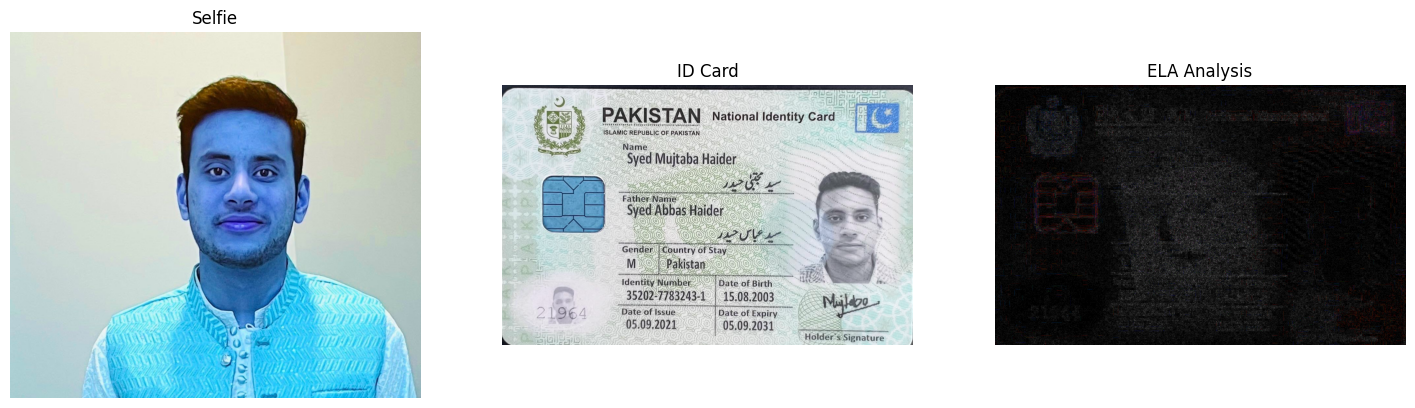

In [34]:
import face_recognition
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import json
import os

# ✅ Set path to your Tesseract installation
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# --- Utility: Show images ---
def show_images_grid(images, titles=None, figsize=(18, 6)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB))
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# --- Load image safely ---
def load_image(input_path):
    if isinstance(input_path, Image.Image):
        return input_path.convert("RGB")
    elif os.path.exists(input_path):
        return Image.open(input_path).convert("RGB")
    else:
        raise ValueError(f"Invalid image input: {input_path}")

# --- Get face encoding correctly ---
def get_face_encoding(image):
    """
    Takes a PIL image, detects the face, and returns its 128D encoding.
    """
    img_np = np.array(image)
    face_locations = face_recognition.face_locations(img_np)

    if len(face_locations) == 0:
        return None, None  # no face found

    encodings = face_recognition.face_encodings(img_np, face_locations)
    return encodings[0], face_locations[0]

# --- Compare encodings ---
def compare_embeddings(enc1, enc2, threshold=0.6):
    if enc1 is None or enc2 is None:
        return None, False
    distance = np.linalg.norm(enc1 - enc2)
    match = distance < threshold
    return distance, match

# --- Error Level Analysis (for tampering detection) ---
def perform_ela_analysis(image, quality=90):
    temp_path = "temp_ela.jpg"
    image.save(temp_path, "JPEG", quality=quality)
    compressed = Image.open(temp_path)
    ela_image = ImageChops.difference(image, compressed)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max(1, max_diff)
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    os.remove(temp_path)
    return ela_image

# --- OCR on ID ---
def ocr_id_data(pil_image):
    data = pytesseract.image_to_data(pil_image, output_type=pytesseract.Output.DICT)
    items = []
    n = len(data['text'])
    for i in range(n):
        txt = data['text'][i].strip()
        conf_val = data['conf'][i]
        # Handle both str and int conf
        if isinstance(conf_val, str):
            conf = int(conf_val) if conf_val.lstrip('-').isdigit() else -1
        else:
            conf = int(conf_val)
        if txt != "":
            items.append({'text': txt, 'conf': conf})
    return items

# --- Verify identity end-to-end ---
def verify_identity_enhanced(selfie_input, id_input, face_threshold=0.6, ela_q=90, ela_threshold=35):
    out = {}

    # 1️⃣ Load images
    selfie_pil = load_image(selfie_input)
    id_pil = load_image(id_input)

    # 2️⃣ Face encodings
    selfie_enc, selfie_face_loc = get_face_encoding(selfie_pil)
    id_enc, id_face_loc = get_face_encoding(id_pil)

    if selfie_enc is None or id_enc is None:
        out['summary'] = {'result': 'Not verified', 'reason': 'Face not detected in one or both images'}
        return out

    dist, match = compare_embeddings(selfie_enc, id_enc, face_threshold)

    # 3️⃣ OCR
    ocr_items = ocr_id_data(id_pil)
    ocr_text = " ".join([i['text'] for i in ocr_items if i['conf'] > 50])

    # 4️⃣ ELA
    ela_img = perform_ela_analysis(id_pil, quality=ela_q)
    ela_gray = ela_img.convert("L")
    ela_np = np.array(ela_gray)
    ela_score = np.mean(ela_np)
    tampered = ela_score > ela_threshold

    # 5️⃣ Summary
    verified = bool(match and not tampered)
    out['summary'] = {
        'Identity verified': verified,
        'Face distance': float(dist),
        'Selfie real': True,
        'ID tampered': bool(tampered),
        'OCR text snippet': ocr_text[:150]
    }

    # 6️⃣ Visualization images
    out['selfie_annotated'] = selfie_pil
    out['id_ocr_annotated'] = id_pil
    out['ela_image'] = ela_img
    return out


# --- Run Verification ---
selfie_path = r"C:\Users\mujta\OneDrive\Desktop\real_me.jpg"
id_path = r"C:\Users\mujta\OneDrive\Desktop\real.jpeg"

res = verify_identity_enhanced(selfie_path, id_path)

print(json.dumps(res['summary'], indent=2))

show_images_grid(
    [res['selfie_annotated'], res['id_ocr_annotated'], res['ela_image']],
    titles=['Selfie', 'ID Card', 'ELA Analysis']
)


{
  "Identity verified": true,
  "Face distance": 0.4243424318665963,
  "Selfie real": true,
  "ID tampered": false,
  "OCR text snippet": "PAKISTAN National Identity card ISLAMIC REPUBLIC OF PAKISTAN \u2018Name Syed MujtabaHaider \u2014 \u201cSs = a) Eee Zz Of ry Identity Date of Birth 35202-7783243-1 | 21964 Date of Expiry = j q"
}


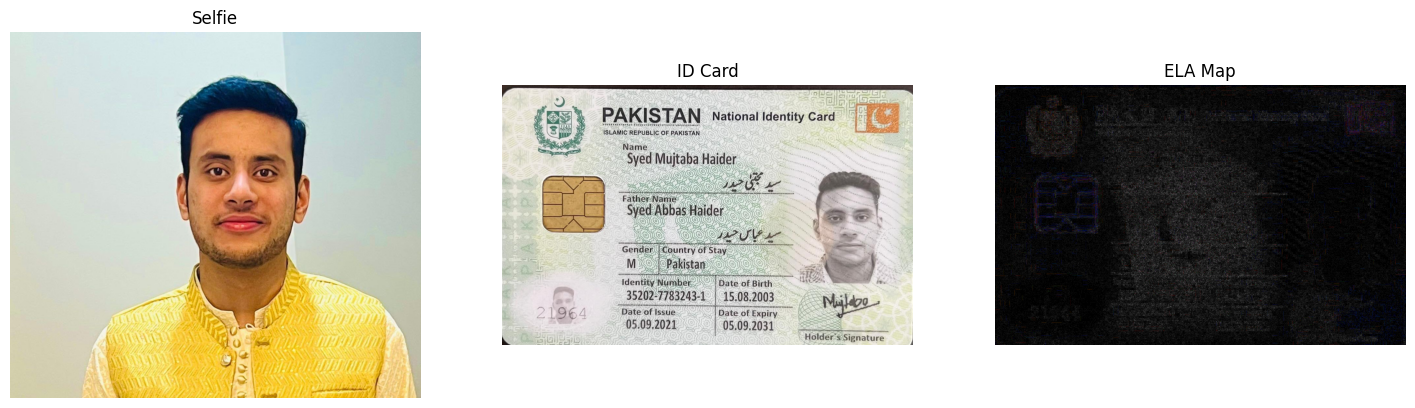

In [36]:
import cv2
import numpy as np
import pytesseract
from PIL import Image, ImageEnhance, ImageFilter, ImageChops
import face_recognition
import matplotlib.pyplot as plt
import json

# ---- Configure Tesseract ----
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# -----------------------------------------------------------
# Helper: Display multiple images
# -----------------------------------------------------------
def show_images_grid(images, titles=None, figsize=(16, 8)):
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis("off")
    plt.show()


# -----------------------------------------------------------
# FACE FUNCTIONS
# -----------------------------------------------------------
def extract_face_and_encoding(image_path):
    """
    Extracts face location and encoding from a full image.
    Returns (face_crop, encoding, full_image)
    """
    img = face_recognition.load_image_file(image_path)
    boxes = face_recognition.face_locations(img)
    if len(boxes) == 0:
        return None, None, img
    encs = face_recognition.face_encodings(img, known_face_locations=boxes)
    if len(encs) == 0:
        return None, None, img
    top, right, bottom, left = boxes[0]
    face_crop = img[top:bottom, left:right]
    return face_crop, encs[0], img


def compare_embeddings(emb1, emb2, threshold=0.6):
    dist = np.linalg.norm(emb1 - emb2)
    return dist, dist < threshold


# -----------------------------------------------------------
# OCR FUNCTIONS (English + Urdu)
# -----------------------------------------------------------
def preprocess_for_ocr(pil_image):
    gray = pil_image.convert("L")
    enhanced = ImageEnhance.Contrast(gray).enhance(2)
    blurred = enhanced.filter(ImageFilter.MedianFilter())
    return blurred


def ocr_id_data(pil_image):
    img = preprocess_for_ocr(pil_image)

    # Multilingual OCR (English + Urdu)
    data = pytesseract.image_to_data(
        img,
        lang="eng+urd",
        config="--psm 6",
        output_type=pytesseract.Output.DICT,
    )

    text_items = []
    for i in range(len(data["text"])):
        txt = str(data["text"][i]).strip()
        conf_val = data["conf"][i]
        conf = int(conf_val) if isinstance(conf_val, (int, float, np.integer)) else -1
        if txt and conf > 40:
            text_items.append(txt)
    return " ".join(text_items)


# -----------------------------------------------------------
# SPOOF DETECTION
# -----------------------------------------------------------
def compute_edge_density(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    return np.sum(edges > 0) / edges.size


def compute_color_variance(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    return np.var(hsv[:, :, 1]) + np.var(hsv[:, :, 2])


def detect_specular_highlights(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 250, 255, cv2.THRESH_BINARY)
    return np.sum(thresh > 0) / thresh.size


def detect_spoof(image, edge_thresh=0.01, color_thresh=500, highlight_thresh=0.01):
    edge_density = compute_edge_density(image)
    color_var = compute_color_variance(image)
    highlight_ratio = detect_specular_highlights(image)

    spoof = (
        edge_density < edge_thresh
        or color_var < color_thresh
        or highlight_ratio > highlight_thresh
    )
    return not spoof, {
        "edge_density": edge_density,
        "color_variance": color_var,
        "highlight_ratio": highlight_ratio,
    }


# -----------------------------------------------------------
# ELA (Error Level Analysis)
# -----------------------------------------------------------
def perform_ela(pil_image, quality=90):
    tmp_path = "temp_ela.jpg"
    pil_image.save(tmp_path, "JPEG", quality=quality)
    resaved = Image.open(tmp_path)
    ela_img = ImageChops.difference(pil_image, resaved)
    extrema = ela_img.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0 / max_diff if max_diff != 0 else 1
    ela_img = ImageEnhance.Brightness(ela_img).enhance(scale)
    return ela_img


def analyze_ela(ela_img, threshold=60):
    ela_np = np.array(ela_img.convert("L"))
    mean_val = np.mean(ela_np)
    return mean_val < threshold, mean_val


# -----------------------------------------------------------
# MAIN FUNCTION
# -----------------------------------------------------------
def verify_identity_enhanced(selfie_path, id_path, face_threshold=0.6):
    out = {}

    # 1️⃣ Face extraction + embeddings
    selfie_face, selfie_emb, selfie_full = extract_face_and_encoding(selfie_path)
    id_face, id_emb, id_full = extract_face_and_encoding(id_path)

    if selfie_emb is None or id_emb is None:
        out["summary"] = {"result": "Face not detected"}
        return out

    dist, match = compare_embeddings(selfie_emb, id_emb, face_threshold)
    out["face_distance"] = dist
    out["face_match"] = match

    # 2️⃣ OCR
    id_pil = Image.open(id_path)
    ocr_text = ocr_id_data(id_pil)
    out["ocr_text"] = ocr_text

    # 3️⃣ Spoof detection
    selfie_rgb = cv2.cvtColor(np.array(Image.open(selfie_path)), cv2.COLOR_BGR2RGB)
    is_real, spoof_metrics = detect_spoof(selfie_rgb)
    out["selfie_real"] = is_real
    out["spoof_metrics"] = spoof_metrics

    # 4️⃣ ELA
    ela_img = perform_ela(id_pil)
    id_not_tampered, ela_score = analyze_ela(ela_img)
    out["id_tampered"] = not id_not_tampered
    out["ela_score"] = ela_score

    # 5️⃣ Summary
    out["summary"] = {
        "Identity verified": bool(match and is_real and id_not_tampered),
        "Face distance": dist,
        "Selfie real": is_real,
        "ID tampered": not id_not_tampered,
        "OCR text snippet": ocr_text[:200],
    }

    out["selfie_annotated"] = selfie_full
    out["id_ocr_annotated"] = id_full
    out["ela_image"] = ela_img

    return out


# -----------------------------------------------------------
# 🧪 Run Verification
# -----------------------------------------------------------
selfie_path = r"C:\Users\mujta\OneDrive\Desktop\real_me.jpg"
id_path = r"C:\Users\mujta\OneDrive\Desktop\real.jpeg"

res = verify_identity_enhanced(selfie_path, id_path)

print(json.dumps(res["summary"], indent=2))

show_images_grid(
    [res["selfie_annotated"], res["id_ocr_annotated"], res["ela_image"]],
    titles=["Selfie", "ID Card", "ELA Map"],
    figsize=(18, 6),
)
